## Dependencies

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Image alignment

Text(0.5, 1.0, 'Target')

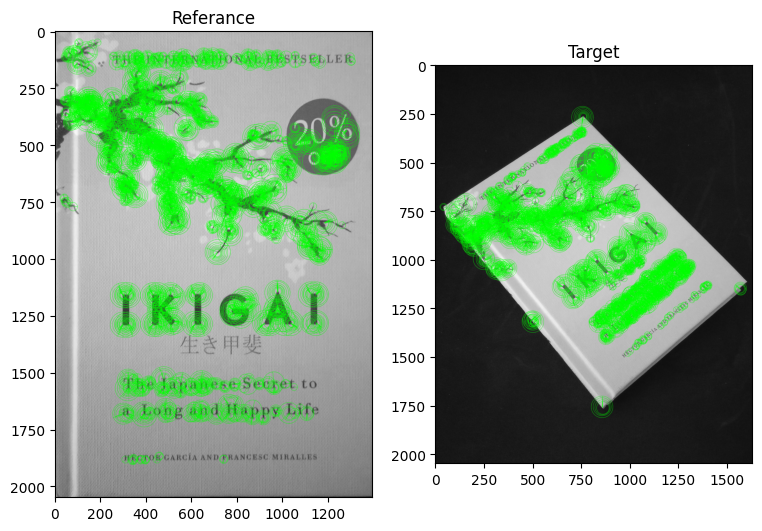

In [2]:
ref1 = cv2.imread('./assets/reference2.jpg',cv2.IMREAD_GRAYSCALE)
target = cv2.imread('./assets/cover.jpg',cv2.IMREAD_GRAYSCALE)

# Detect features using orb
orb = cv2.ORB.create(nfeatures=3000)
keypt1, descpt1 = orb.detectAndCompute(ref1,None)
keypt2,descpt2 = orb.detectAndCompute(target,None)

# Draw matches
ref1_display = cv2.drawKeypoints(ref1,keypt1,outImage=np.array([]),color=(0,255,0),flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
target_display = cv2.drawKeypoints(target,keypt2,outImage=np.array([]),color=(0,255,0),flags=cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS)


plt.figure(figsize=(9,16))
plt.subplot(1,2,1)
plt.imshow(ref1_display,cmap='gray')
plt.title('Referance')

plt.subplot(1,2,2)
plt.imshow(target_display,cmap='gray')
plt.title('Target')


Text(0.5, 1.0, 'Original Form')

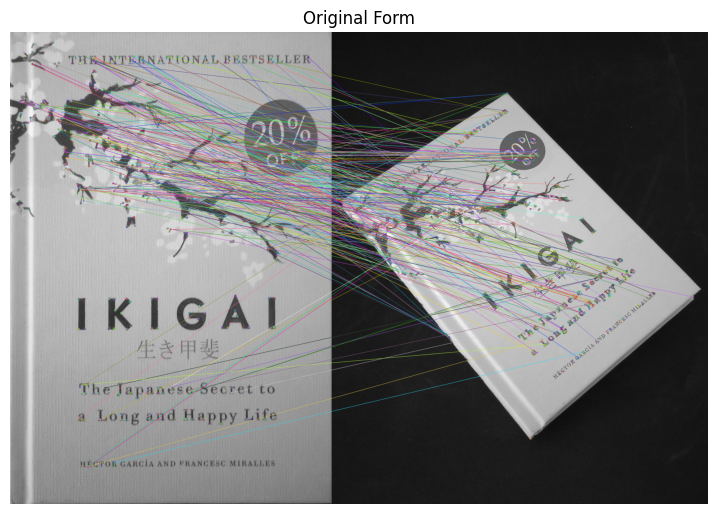

In [ ]:
## Match Features

matcher = cv2.DescriptorMatcher.create(cv2.DescriptorMatcher_BRUTEFORCE_HAMMING)
matches = matcher.match(descpt1,descpt2,None)

matches = sorted(matches,key=lambda x: x.distance)
good_matches = int(len(matches)*0.1)
matches = matches[:good_matches]

feature_matches = cv2.drawMatches(ref1,keypt1,target,keypt2,matches,None)
plt.figure(figsize=(9,16))
plt.imshow(feature_matches)
plt.axis('off')
plt.title('Original Form')

In [4]:
# Extract location of good matches
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)

for i, match in enumerate(matches):
    points1[i, :] = keypt1[match.queryIdx].pt
    points2[i, :] = keypt2[match.trainIdx].pt

# Find homography
h, mask = cv2.findHomography(points2, points1, cv2.RANSAC)


In [7]:
ref1.shape

(2048, 1394)

Text(0.5, 1.0, 'Scanned Form')

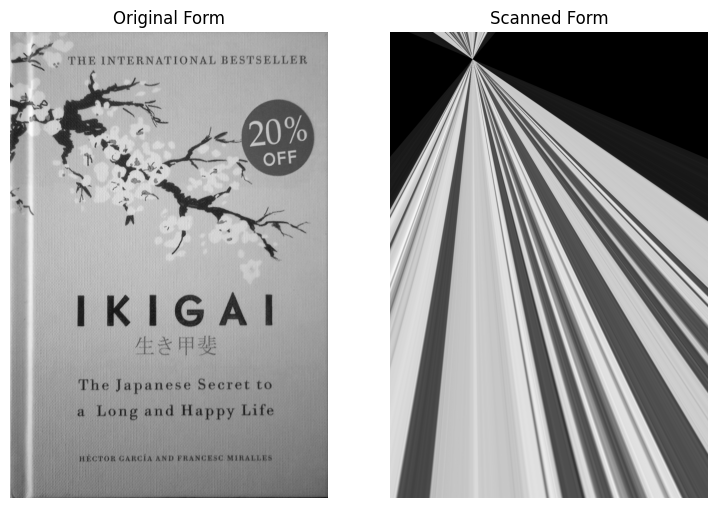

In [9]:
# Step 5: Warp image

# Use homography to warp image
height, width = ref1.shape
warped_target = cv2.warpPerspective(target, h, (width, height))

# Display results
plt.figure(figsize=(9,16))
plt.subplot(1,2,1)
plt.imshow(ref1,cmap='gray')
plt.axis('off')
plt.title("Original Form")

plt.subplot(1,2,2)
plt.imshow(warped_target,cmap='gray')
plt.axis('off')
plt.title("Scanned Form")


## Document processing

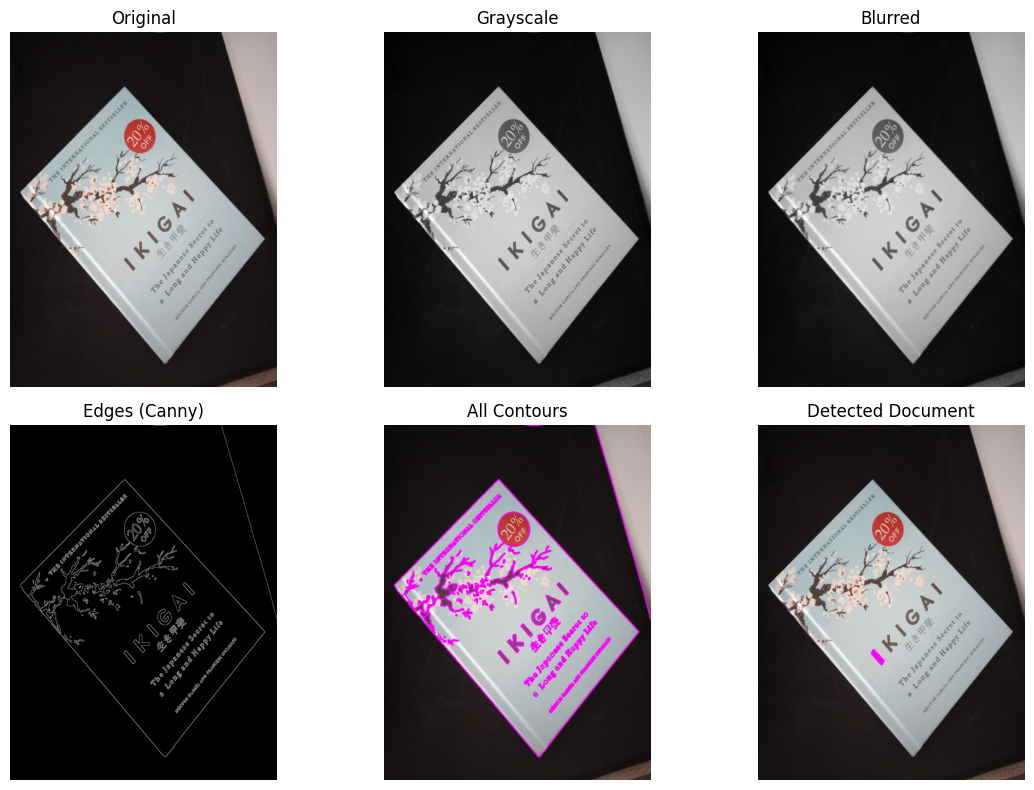

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load and resize image
img = cv2.imread("./assets/cover.jpg")
img = cv2.resize(img, (960, 1280))  # Resize for better processing

# Convert to grayscale and apply Gaussian blur
GrayImg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
BlurredFrame = cv2.GaussianBlur(GrayImg, (5, 5), 1)

# Canny Edge Detection
CannyFrame = cv2.Canny(BlurredFrame, 50, 150)

# Find contours
contours, _ = cv2.findContours(CannyFrame, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw all contours
ContourFrame = img.copy()
cv2.drawContours(ContourFrame, contours, -1, (255, 0, 255), 3)

# Find the biggest quadrilateral (document)
CornerFrame = img.copy()
maxArea = 0
biggest = np.array([])

for i in contours:
    area = cv2.contourArea(i)
    if area > 500:
        peri = cv2.arcLength(i, True)
        edges = cv2.approxPolyDP(i, 0.02 * peri, True)
        if area > maxArea and len(edges) == 4:  # Ensure it's a quadrilateral
            biggest = edges
            maxArea = area

# Draw only the detected document's contour
if biggest.size != 0:
    cv2.polylines(CornerFrame, [biggest], isClosed=True, color=(255, 0, 255), thickness=10)

# Resize images for Matplotlib
size = (480, 640)
img = cv2.resize(img, size)
GrayImg = cv2.resize(GrayImg, size)
BlurredFrame = cv2.resize(BlurredFrame, size)
CannyFrame = cv2.resize(CannyFrame, size)
ContourFrame = cv2.resize(ContourFrame, size)
CornerFrame = cv2.resize(CornerFrame, size)

# Convert BGR to RGB for Matplotlib
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
ContourFrame = cv2.cvtColor(ContourFrame, cv2.COLOR_BGR2RGB)
CornerFrame = cv2.cvtColor(CornerFrame, cv2.COLOR_BGR2RGB)

# Display results using Matplotlib
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

axes[0, 0].imshow(img)
axes[0, 0].set_title("Original")

axes[0, 1].imshow(GrayImg, cmap='gray')
axes[0, 1].set_title("Grayscale")

axes[0, 2].imshow(BlurredFrame, cmap='gray')
axes[0, 2].set_title("Blurred")

axes[1, 0].imshow(CannyFrame, cmap='gray')
axes[1, 0].set_title("Edges (Canny)")

axes[1, 1].imshow(ContourFrame)
axes[1, 1].set_title("All Contours")

axes[1, 2].imshow(CornerFrame)
axes[1, 2].set_title("Detected Document")

# Hide axes for a cleaner look
for ax in axes.ravel():
    ax.axis("off")

plt.tight_layout()
plt.show()
